In [1]:
import time
notebookstart= time.time()

In [2]:
import torch

C:\Users\_v010ch_\Anaconda3\envs\uly22\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
from typing import Tuple

import pandas as pd
import numpy as np

from PIL import Image
from pillow_heif import register_heif_opener
register_heif_opener() # for using Image.open for .heic without changes

from tqdm.auto import tqdm
tqdm.pandas()

In [63]:
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
%matplotlib inline

In [4]:
DIR_SUBM = os.path.join(os.getcwd(), 'subm')
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [5]:
test_img_names  = set(os.listdir(DIR_DATA_TEST))
train_img_names = set(os.listdir(DIR_DATA_TRAIN))
len(test_img_names), len(train_img_names)

(521, 530)

In [6]:
train_labels_df = pd.read_csv(os.path.join(DIR_DATA, 'train.csv'), sep=';', index_col=None)

In [7]:
def get_car_center(inp_tensor: torch.Tensor) -> Tuple[int, int]:

    car_cntr = (int((inp_tensor[2].int().item() - inp_tensor[0].int().item())/2 + inp_tensor[0].int().item()),
                int((inp_tensor[3].int().item() - inp_tensor[1].int().item())/2 + inp_tensor[1].int().item())
        )
    
    return car_cntr

In [8]:
def get_center_dist(inp_center: Tuple[int, int], inp_point: Tuple[int, int]) -> float:
    
    return np.sqrt((inp_center[0] - inp_point[0])**2 + \
                   (inp_center[1] - inp_point[1])**2)

In [9]:
def determine_targ_car(inp_results, inp_img_cntr: Tuple[int, int]) -> int:
    
    min = 1000000

    for el in range(inp_results.xyxy[0].shape[0]):
        car_cntr = get_car_center(inp_results.xyxy[0][el])
        cur_dist = get_center_dist(inp_img_cntr, car_cntr)
        if cur_dist < min:
            min = cur_dist
            min_idx = el

    return min_idx

In [87]:
def create_feeatures(inp_fnames, inp_dir, inp_model, use_centr = False):
    
    ret_data = []

    for img_name in tqdm(inp_fnames): 
        #if 'heic' in img_name:
        #    heif_file = pyheif.read(os.path.join(inp_dir, img_name))
        #   img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
        #else:
        #    img = Image.open(os.path.join(inp_dir, img_name))
        img = Image.open(os.path.join(inp_dir, img_name))

        #img_ = np.array(img)
        results = model(np.array(img))
    
        if results.xyxy[0].shape != torch.Size([0, 6]):

            if use_centr:
                img_cntr = (int(img_.shape[1]/2), int(img_.shape[0]/2))
                target_goal = determine_targ_car(results, img_cntr)
            else:
                target_goal = 0

            h = results.xyxy[0][target_goal][3] - results.xyxy[0][target_goal][1]
            w = results.xyxy[0][target_goal][2] - results.xyxy[0][target_goal][0]
            results = results.xyxy[0][target_goal].numpy().tolist() + [h.item(), w.item()]
            
            # позволим алгоритмам самим выбирать как заполнить пропуски
            ret_data.append([img_name] + results)
            
            
        else:
            print(f'wtf, {img_name}   {results.xyxy[0].shape}')
            # позволим алгоритмам самим выбирать как заполнить пропуски
            #results = [0, 0, 0, 0, 0, 0, 0, 0]

# позволим алгоритмам самим выбирать как заполнить пропуски
#        ret_data.append([img_name] + results)
        
    ret_data = pd.DataFrame(ret_data, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class', 'h', 'w'])
        
    return ret_data

In [18]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model.classes = [0, 2]  # person and car
_ = model.cpu()

Using cache found in C:\Users\_v010ch_/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-8-3 Python-3.10.4 torch-1.12.0 CUDA:0 (GeForce GTX 1050 Ti, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [88]:
train_df = create_feeatures(train_img_names, DIR_DATA_TRAIN, model) #use_centr
train_df = pd.merge(train_labels_df, train_df, how='left')
train_df.shape

  8%|██████▎                                                                          | 41/530 [00:21<04:13,  1.93it/s]

wtf, img_2570.jpg   torch.Size([0, 6])


 27%|█████████████████████▎                                                          | 141/530 [01:18<03:08,  2.06it/s]

wtf, img_2765.jpg   torch.Size([0, 6])


 78%|██████████████████████████████████████████████████████████████▋                 | 415/530 [03:49<00:59,  1.94it/s]

wtf, img_2745.jpg   torch.Size([0, 6])


 85%|████████████████████████████████████████████████████████████████████            | 451/530 [04:10<00:43,  1.82it/s]

wtf, img_2764.jpg   torch.Size([0, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 530/530 [04:58<00:00,  1.78it/s]


(530, 10)

In [89]:
test_df = create_feeatures(test_img_names, DIR_DATA_TEST, model) #use_centr
test_df.shape

 12%|█████████▊                                                                       | 63/521 [00:36<04:09,  1.84it/s]

wtf, img_2938.jpg   torch.Size([0, 6])


 18%|██████████████▎                                                                  | 92/521 [00:52<04:40,  1.53it/s]

wtf, img_2571.jpg   torch.Size([0, 6])


 58%|██████████████████████████████████████████████▋                                 | 304/521 [02:55<03:25,  1.06it/s]

wtf, img_2674.heic   torch.Size([0, 6])


 79%|██████████████████████████████████████████████████████████████▊                 | 409/521 [03:57<00:55,  2.01it/s]

wtf, img_1629.jpg   torch.Size([0, 6])


100%|████████████████████████████████████████████████████████████████████████████████| 521/521 [04:59<00:00,  1.74it/s]


(517, 9)

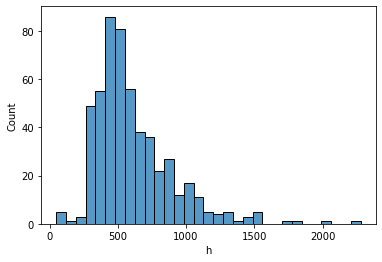

In [90]:
sns.histplot(train_df, x='h')
plt.show()

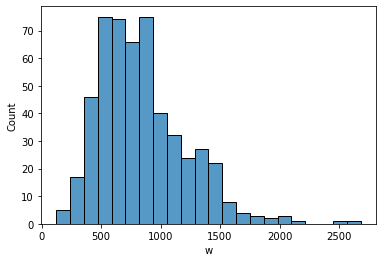

In [91]:
sns.histplot(train_df, x='w')
plt.show()

In [92]:
train_df.head(20)

,image_name,distance,x_min,y_min,x_max,y_max,conf,class,h,w
0,img_1596.jpg,4.88,1664.946045,1180.270630,2279.794434,1715.034180,0.765476,2.0,534.763550,614.848389
1,img_1600.jpg,1.54,518.410889,1144.958374,1430.319336,1757.429810,0.879383,2.0,612.471436,911.908447
2,img_1601.jpg,3.68,2443.314697,1339.932617,3042.800781,1779.703003,0.869439,2.0,439.770386,599.486084
3,img_1603.jpg,2.22,2609.617920,1269.794922,3321.687988,1847.752930,0.911404,2.0,577.958008,712.070068
4,img_1605.jpg,3.73,2485.785889,1233.717041,3120.986328,1677.980591,0.891404,2.0,444.263550,635.200439
5,img_1606.jpg,4.52,2404.588867,1131.827026,2960.893799,1542.262573,0.869874,2.0,410.435547,556.304932
6,img_1607.jpg,5.40,2975.591553,1375.613037,4020.673340,2377.658691,0.831510,2.0,1002.045654,1045.081787
7,img_1608.jpg,6.21,2376.572021,1286.831421,2854.692139,1610.867554,0.897462,2.0,324.036133,478.120117
8,img_1612.jpg,7.12,2668.406250,1395.103271,4032.000000,2252.246582,0.936597,2.0,857.143311,1363.593750
9,img_1613.jpg,5.26,2879.098633,1226.418335,4021.776855,2275.527832,0.868660,2.0,1049.109497,1142.678223


In [93]:
train_df.to_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index = False)
test_df.to_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index = False)